# YouTube Trending Videos Analysis

### Importing required libraries:

In [1]:
import pandas as pd
import numpy as np
import warnings
import regex as re
warnings.filterwarnings('ignore')#to filter all the warnings
import seaborn as sns
pd.set_option('float_format', '{:.4f}'.format)# to keep the float values short
# Import for wordcloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#import fot plotly
import plotly.express as px

## Dataset Description

### YouTube Trending Statistics - Consists of updated daily records of top trending YouTube videos, based on viewership metrics such as likes, dislikes and views and provides interesting parameters such as tag or country for further analysis.

 


### File type: csv
<ol>
    <li>video_id: Uniquely identifies each video</li>
    <li>published_at: Date and Time of video published</li>
    <li>categoryId: Id of category the video belongs to</li>
    <li>trending_date: Date and time when the video got to Trending</li>
    <li>view_count: Number of views (cumulative)</li>
    <li>likes: Number of Likes(cumulative)</li>
    <li>dislikes: Number of dislikes(cumulative)</li>
    <li>comment_count: Number of comments(cumulative)</li>
    <li>country: Country in which the video was trending</li>
    <li>description: Description of video by the creator</li>
    <li>tags: Tags of the video by the creator</li>
    <li>title: Title of the video</li>
    <li>channelTitle: Channel Title of the video</li>
    <li>thumbnail_link:link for thumbnails</li>
    <li>comments_disabled: boolean value that defines if viewer can comment</li>
    <li>ratings_disabled: boolean value that defines if viewer can rate through likes and dislikes</li>
    <li>channelId: uniquely defines the channel the video is coming from</li>
</ol>

### File type: json
<ol>
<li>id: Id of category the video belongs to</li>
<li>name: Respective category names of category ids</li>  
</ol>


### Importing individual .csv file of USA, Great Britain, Canada from Home directory:

In [2]:
US_Videos_df = pd.read_csv('US_youtube_trending_data.csv')
US_Videos_df.head(1)

video_id                               title           publishedAt  \
0  3C66w5Z0ixs  I ASKED HER TO BE MY GIRLFRIEND...  2020-08-11T19:20:14Z   

                  channelId channelTitle  categoryId         trending_date  \
0  UCvtRTOMP2TqYqu51xNrqAzg     Brawadis          22  2020-08-12T00:00:00Z   

                                                tags  view_count   likes  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908   

   dislikes  comment_count                                  thumbnail_link  \
0      5855          35313  https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg   

   comments_disabled  ratings_disabled  \
0              False             False   

                                         description  
0  SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...

In [3]:
CA_Videos_df = pd.read_csv('CA_youtube_trending_data.csv')
CA_Videos_df.head(1)

video_id                                              title  \
0  KX06ksuS6Xo  Diljit Dosanjh: CLASH (Official) Music Video |...   

            publishedAt                 channelId    channelTitle  categoryId  \
0  2020-08-11T07:30:02Z  UCZRdNleCgW-BGUJf-bbjzQg  Diljit Dosanjh          10   

          trending_date                                               tags  \
0  2020-08-12T00:00:00Z  clash diljit dosanjh|diljit dosanjh|diljit dos...   

   view_count   likes  dislikes  comment_count  \
0     9140911  296541      6180          30059   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/KX06ksuS6Xo/default.jpg              False   

   ratings_disabled                                        description  
0             False  CLASH official music video performed by DILJIT...

In [4]:
GB_Videos_df = pd.read_csv('GB_youtube_trending_data.csv')
GB_Videos_df.head(1)

video_id                                              title  \
0  J78aPJ3VyNs  I left youtube for a month and THIS is what ha...   

            publishedAt                 channelId   channelTitle  categoryId  \
0  2020-08-11T16:34:06Z  UCYzPXprvl5Y-Sf0g4vX-m6g  jacksepticeye          24   

          trending_date                                               tags  \
0  2020-08-12T00:00:00Z  jacksepticeye|funny|funny meme|memes|jacksepti...   

   view_count   likes  dislikes  comment_count  \
0     2038853  353790      2628          40228   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg              False   

   ratings_disabled                                        description  
0             False  I left youtube for a month and this is what ha...

### Finding the shape of these 3 dataframes

In [5]:
print('Shape of GB File: '+ str(GB_Videos_df.shape))
print('Shape of CA File: '+ str(CA_Videos_df.shape))
print('Shape of US File: '+ str(US_Videos_df.shape))

Shape of GB File: (92395, 16)
Shape of CA File: (92344, 16)
Shape of US File: (92391, 16)


### Opening JSON file and loading the required data to match categoryId to its respective category name:

The dataset we downloaded from Kaggle has two types of files for each country, one is 'video.csv' which contains all the features described before, and the other is 'category.json' which contains mapping for category id to category names.

To merge this information together, we did the following steps:

**1. Load JSON File for each country**

In [6]:
import json #import data using python json module
with open('US_category_id.json','r') as f:
    category_data_us= json.loads(f.read())

In [7]:
with open('CA_category_id.json','r') as f:
    category_data_ca= json.loads(f.read())

In [8]:
with open('GB_category_id.json','r') as f:
    category_data_gb= json.loads(f.read())

**2. Since JSON file was in nested format we used json normalize function from pandas to flatten it and read into data frame**



In [9]:
US_cat = pd.json_normalize(category_data_us,record_path='items')
CA_cat = pd.json_normalize(category_data_ca,record_path='items')
GB_cat = pd.json_normalize(category_data_gb,record_path='items')

In [10]:
# Converting the 'id' extracted from the json file to type 'int'
US_cat['id']= US_cat['id'].astype(int)
CA_cat['id']= CA_cat['id'].astype(int)
GB_cat['id']= GB_cat['id'].astype(int)

**3. Merging videos dataframe and category dataframe for all countries using left join**

In [11]:
US_Videos_df= US_Videos_df.merge(US_cat,how ='left',left_on= 'categoryId',\
                                 right_on='id').rename(columns= {'snippet.title':'category_name'})
CA_Videos_df= CA_Videos_df.merge(CA_cat,how ='left',left_on= 'categoryId',\
                                 right_on='id').rename(columns= {'snippet.title':'category_name'})
GB_Videos_df= GB_Videos_df.merge(GB_cat,how ='left',left_on= 'categoryId',\
                                 right_on='id').rename(columns= {'snippet.title':'category_name'})

### Noting the shape again after the merge

In [12]:
print('Shape of GB File: '+ str(GB_Videos_df.shape))
print('Shape of CA File: '+ str(CA_Videos_df.shape))
print('Shape of US File: '+ str(US_Videos_df.shape))

Shape of GB File: (92395, 22)
Shape of CA File: (92344, 22)
Shape of US File: (92391, 22)


### Adding a column 'country' to identify country specific information after appending the 3 countries - USA, Great Britain, Canada

In [13]:
US_Videos_df['country']= 'USA'
CA_Videos_df['country']= 'Canada'
GB_Videos_df['country']= 'Great Britain'

In [14]:
US_Videos_df.head(1)

video_id                               title           publishedAt  \
0  3C66w5Z0ixs  I ASKED HER TO BE MY GIRLFRIEND...  2020-08-11T19:20:14Z   

                  channelId channelTitle  categoryId         trending_date  \
0  UCvtRTOMP2TqYqu51xNrqAzg     Brawadis          22  2020-08-12T00:00:00Z   

                                                tags  view_count   likes  ...  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908  ...   

   comments_disabled  ratings_disabled  \
0              False             False   

                                         description                   kind  \
0  SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...  youtube#videoCategory   

                          etag  id   category_name snippet.assignable  \
0  QMEBz6mxVdklVaq8JwesPEw_4nI  22  People & Blogs               True   

          snippet.channelId country  
0  UCBR8-60-B28hp2BmDPdntcQ     USA  

[1 rows x 23 columns]

### Appending Data from 3 countries:

#### Making a list of all countries and using pd.concat function to append data for all countries in one dataframe

In [15]:
df_list= [US_Videos_df,CA_Videos_df,GB_Videos_df]

In [16]:
df= pd.concat(df_list).reset_index(drop=True)

In [17]:
df.groupby('country')['video_id'].count()

country
Canada           92344
Great Britain    92395
USA              92391
Name: video_id, dtype: int64

In [18]:
df.shape

(277130, 23)

# Data Cleaning

#### Dropping columns that are irrelevant for analysis:

In [19]:
df.drop(columns=['thumbnail_link','kind','etag','id','snippet.assignable','snippet.channelId','channelId'], axis='columns').shape

(277130, 16)

#### The above code is a proof that the columns mentioned are safely dropped without disturbing the rows.So,using inplace= True parameter with drop

In [20]:
df.drop(columns=['thumbnail_link','kind','etag','id','snippet.assignable',\
                 'snippet.channelId','channelId'], axis='columns',inplace=True)

In [21]:
df.head(1)

video_id                               title           publishedAt  \
0  3C66w5Z0ixs  I ASKED HER TO BE MY GIRLFRIEND...  2020-08-11T19:20:14Z   

  channelTitle  categoryId         trending_date  \
0     Brawadis          22  2020-08-12T00:00:00Z   

                                                tags  view_count   likes  \
0  brawadis|prank|basketball|skits|ghost|funny vi...     1514614  156908   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0      5855          35313              False             False   

                                         description   category_name country  
0  SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...  People & Blogs     USA

### Data coherency

#### Finding if there are any True values in comments_disabled and ratings_disabled columns, which represents that comment_count is 0 if  comments_disabled is True, and likes ,dislikes should be 0 if ratings_disabled is True

In [22]:
df[df.comments_disabled==True]['comment_count'].head()

53     0
131    0
134    0
242    0
276    0
Name: comment_count, dtype: int64

In [23]:
df[df.ratings_disabled==True][['likes','dislikes']].sample(5)

likes  dislikes
50005       0         0
30607       0         0
187128      0         0
253366      0         0
144763      0         0

In [24]:
df[df.comments_disabled==True].comment_count.sum()

0

In [25]:
df[df.ratings_disabled==True][['likes','dislikes']].sum()

likes       0
dislikes    0
dtype: int64

##### The records with True values in Comments_disabled and ratings_disabled have 0 corresponding values(likes, dislikes,comment_count).Hence the data is coherent and it is safe to drop the above 2 columns

In [26]:
df.drop(columns=['comments_disabled','ratings_disabled'],axis=1,inplace=True)

In [27]:
df.shape

(277130, 14)

### Checking for Null values

In [28]:
df.isna().sum()

video_id            0
title               0
publishedAt         0
channelTitle        0
categoryId          0
trending_date       0
tags                0
view_count          0
likes               0
dislikes            0
comment_count       0
description      4541
category_name     164
country             0
dtype: int64

#### There are null values in category_name and description
#### 1. Dealing with Category_name null values 
#### 2. Dealing with description null values

#### 1. Dealing with null values in category_name

In [29]:
df[df.category_name.isna()].head()

video_id                                              title  \
96874  zvxrdwbmnHU  Nisswa Mayor Arrested for Involvement in Traff...   
97107  zvxrdwbmnHU  Nisswa Mayor Arrested for Involvement in Traff...   
97325  zvxrdwbmnHU  Nisswa Mayor Arrested for Involvement in Traff...   
97555  zvxrdwbmnHU  Nisswa Mayor Arrested for Involvement in Traff...   
97671  P5urIeEcuvA                         Miley Cyrus quits veganism   

                publishedAt  channelTitle  categoryId         trending_date  \
96874  2020-09-01T04:50:02Z  Lakeland PBS          29  2020-09-03T00:00:00Z   
97107  2020-09-01T04:50:02Z  Lakeland PBS          29  2020-09-04T00:00:00Z   
97325  2020-09-01T04:50:02Z  Lakeland PBS          29  2020-09-05T00:00:00Z   
97555  2020-09-01T04:50:02Z  Lakeland PBS          29  2020-09-06T00:00:00Z   
97671  2020-09-05T18:17:10Z  Earthling Ed          29  2020-09-07T00:00:00Z   

                                                    tags  view_count  likes  \
96874         Lakeland PBS|LPTV|PBS|Bemidji|Minnesota|MN      345993   5829   
97107         Lakeland PBS|LPTV|PBS|Bemidji|Minnesota|MN      408941   6578   
97325         Lakeland PBS|LPTV|PBS|Bemidji|Minnesota|MN      447580   7233   
97555         Lakeland PBS|LPTV|PBS|Bemidji|Minnesota|MN      469103   7607   
97671  earthlinged|earthling ed|vegan|veganism|why|be...      132065  14258   

       dislikes  comment_count  \
96874       172           3209   
97107       187           3533   
97325       198           3828   
97555       208           4000   
97671       380           2822   

                                             description category_name country  
96874  Originally aired August 31, 2020For more infor...           NaN  Canada  
97107  Originally aired August 31, 2020For more infor...           NaN  Canada  
97325  Originally aired August 31, 2020For more infor...           NaN  Canada  
97555  Originally aired August 31, 2020For more infor...           NaN  Canada  
97671  ✺ find out more about what i do & sign up for ...           NaN  Canada

In [30]:
df[df.categoryId==29].category_name

4474      Nonprofits & Activism
4690      Nonprofits & Activism
4897      Nonprofits & Activism
5132      Nonprofits & Activism
5383      Nonprofits & Activism
                  ...          
269102                      NaN
274761                      NaN
275009                      NaN
275263                      NaN
275501                      NaN
Name: category_name, Length: 252, dtype: object

In [31]:
df[df.category_name.isna()]['title'].unique()

array(['Nisswa Mayor Arrested for Involvement in Traffic Stop',
       'Miley Cyrus quits veganism',
       'Fast Times At Ridgemont High | Virtual Table Read for CORE',
       '[Full livestream] Watch the Countdown Global Launch, a call to action on climate change',
       'RETURNING To YouTube? Our CHARITY FUNDRAISER! (Ft. Orla Gartland)',
       'It Counts', 'Happy Birthday, #TeamTrees!',
       'The cast of Glee pays tribute to Naya Rivera & Santana Lopez at the 32nd Annual GLAAD Media Awards',
       'Color the Spectrum LIVE- Mark Rober and Jimmy Kimmel',
       'Global Citizen VAX Live - Extended Concert Only on YouTube',
       "I Was Hacked. But Now I'm BACK!",
       'President Moon Jae-in & BTS at the Sustainable Development Goals Moment | United Nations (English)',
       'BTS Shine Spotlight on the United Nations as Envoys of the President of the Republic of Korea',
       'BTS (방탄소년단) at Global Citizen Live Concert - Permission to Dance | #GlobalCitizenLive',
       'Coldp

#### For categoryID=29 , USA has a category name NonProfits&Activism whereas CA,GB did not define a categoryname. By taking a look at the Video title of those records,we can come to a conclusion that they represent  NonProfits&Activists category. So, replacing Nan's with NonProfits&Activism.

In [32]:
df.category_name.fillna('Nonprofits & Activism').isna().any()

False

In [33]:
df.category_name.fillna('Nonprofits & Activism',inplace=True)

#### 2. Dealing with Null values in description
##### filling missing values in description with ''

In [34]:
df.description.fillna('')

0         SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1         While running her own modding shop, Ramya Pare...
2         I left youtube for a month and this is what ha...
3         Subscribe to XXL → http://bit.ly/subscribe-xxl...
4         Transforming The LaBrant Family's empty white ...
                                ...                        
277125    Mariah Carey, Khalid, & Kirk Franklin – Fall I...
277126    Amelia meets Ed Sheeran at Sam’s Chicken for a...
277127    Official visualiser for Westlife's 'My Hero', ...
277128    Seen something you like? Why not hunt for it i...
277129    Salma Hayek is an Academy Award-nominated actr...
Name: description, Length: 277130, dtype: object

In [35]:
df.description.fillna('').isna().any()

False

In [36]:
df.description.fillna('',inplace=True)

#### Understanding data in descriptive columns

In [37]:
df.tags.sample(4)

69708                            noahj456|noah|noahj|gaming
137719                                               [None]
235461    tommyinnit|vlog|in real life|minecraft|ksi|in|...
203409    farah dhukai|sal ali|pregnancy|pregnancy annou...
Name: tags, dtype: object

In [38]:
df.title.sample(4)

69544                         Undercover Boss is Ridiculous
200542    NEW CELEBRATION INCOMING!! I WAX LYRICAL FT RH...
136339    Demi Lovato: Dancing With the Devil | Live Pre...
37366     Kele, Giovakartoons & Etervidos - Por Lo Mio (...
Name: title, dtype: object

In [39]:
df.channelTitle.sample(4)

194847    Legend Of Winning
41811           Jack Harlow
228696            NPR Music
108201        The Herbert's
Name: channelTitle, dtype: object

In [40]:
df.description.sample(4)

168633    La musique est disponible dès maintenant sur t...
69203     ► SUBSCRIBE to GameToons Gaming! -https://www....
30547     Please  subscribe to 【李子柒 Liziqi 】Liziqi Chann...
133396    Enjoy the best of the action as goals from Bru...
Name: description, dtype: object

### The function defined below checks if the text contains non english characters or not

In [41]:
def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [42]:
isEnglish('slabiky, ale liší se podle významu')

False

In [43]:
isEnglish('This sentence is in English')

True

### Function to remove non english characters from the text:

In [44]:
def removeNonEnglishWords(text):
    filteredText = []
    for word in text.split():
        if isEnglish(word):
            filteredText.append(word)
    
    return " ".join(filteredText)
        

#### Validating the function 'removeNonEnglishWords'

In [45]:
text = "‣ what was tekoi:  tekoi commentary:   old version of tekoi:  crowdfundersbob kunz, john buchan, nevin spoljaric, donal botkin, bn-12, chris chapin, richard jenkins, phil gardner, martin, steven grimm, سليمان العقل, david f watson, colin millions, saki comandao, ben schwab, jason lewandowski, marco arment, shantanu raj, rictic, emptymachine, george lin, henry ng, thunda plum, awoo, david tyler, fuesu, iulus, jordan earls, joshua jamison, nick fish, nick gibson, tyler bryant, zach whittle, oliver steele, kermit norlund, kevin costello, derek bonner, derek jackson, mikko , orbit_junkie, ron bowes, tómas árni jónasson, bryan mclemore, alex simonides, felix weis, melvin sowah, christopher mutchler, giulio bontadini, paul alom, ryan tripicchio, scot melville, bear, chrysilis, david palomares, emil, erik parasiuk, esteban santana santana, freddi hørlyck, john rogers, leon, peter lomax, rhys parry, shiroiyami, tristan watts-willis, veronica peshterianu, dag viggo lokøen, john lee, maxime zielony, julien dubois, elizabeth keathley, nicholas welna## musicdavid rees:"
print(removeNonEnglishWords(text))

what was tekoi: tekoi commentary: old version of tekoi: crowdfundersbob kunz, john buchan, nevin spoljaric, donal botkin, bn-12, chris chapin, richard jenkins, phil gardner, martin, steven grimm, david f watson, colin millions, saki comandao, ben schwab, jason lewandowski, marco arment, shantanu raj, rictic, emptymachine, george lin, henry ng, thunda plum, awoo, david tyler, fuesu, iulus, jordan earls, joshua jamison, nick fish, nick gibson, tyler bryant, zach whittle, oliver steele, kermit norlund, kevin costello, derek bonner, derek jackson, mikko , orbit_junkie, ron bowes, bryan mclemore, alex simonides, felix weis, melvin sowah, christopher mutchler, giulio bontadini, paul alom, ryan tripicchio, scot melville, bear, chrysilis, david palomares, emil, erik parasiuk, esteban santana santana, freddi john rogers, leon, peter lomax, rhys parry, shiroiyami, tristan watts-willis, veronica peshterianu, dag viggo john lee, maxime zielony, julien dubois, elizabeth keathley, nicholas welna## m

#### Creating a flag to check if each record in description is in English

In [46]:
df['isEnglish'] = df.description.apply(lambda s: isEnglish(s))

In [47]:
df.isEnglish.value_counts()

False    179161
True      97969
Name: isEnglish, dtype: int64

#### False--- indicates the presence of non- English characters in description
#### True---- indicates all the words in its description are in English

In [48]:
df[df.isEnglish==False].description

0         SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1         While running her own modding shop, Ramya Pare...
2         I left youtube for a month and this is what ha...
3         Subscribe to XXL → http://bit.ly/subscribe-xxl...
5         Subscribe To My Channel - https://www.youtube....
                                ...                        
277125    Mariah Carey, Khalid, & Kirk Franklin – Fall I...
277126    Amelia meets Ed Sheeran at Sam’s Chicken for a...
277127    Official visualiser for Westlife's 'My Hero', ...
277128    Seen something you like? Why not hunt for it i...
277129    Salma Hayek is an Academy Award-nominated actr...
Name: description, Length: 179161, dtype: object

#### adding a new feature des (with cleaned description ) into the dataframe

In [49]:
df['des']= df.description.apply(removeNonEnglishWords)

In [50]:
df[['description','des']].sample(5)

description  \
213701  Gary Anderson preview Gezzy Price World Champi...   
167040  Get your tickets to Roadkill Nights here►https...   
39639   THE HERMES MCLAREN SPEEDTAIL IS FINALLY HERE!►...   
80936   Videos like this are only possible with your h...   
276580  I got my brother his dream apartment in London...   

                                                      des  
213701  Gary Anderson preview Gezzy Price World Champi...  
167040  Get your tickets to Roadkill Nights out my Dod...  
39639   THE HERMES MCLAREN SPEEDTAIL IS FINALLY Thanks...  
80936   Videos like this are only possible with your h...  
276580  I got my brother his dream apartment in Subscr...

#### From the above code, des column has only the words in that are in English .So it is safe to drop Description and isEnglish(flag) column.

In [51]:
df.drop(columns=['description','isEnglish'],axis=1,inplace=True)

#### Now applying the same logic on tags, title and channel_title  columns to ensure the presence of just English words

##### Tags cleaning:

In [52]:
df['isEnglish'] = df.tags.apply(lambda s: isEnglish(s))
df[df.isEnglish==False].tags.count()# finding the number of tags that consists of non english characters

22448

##### adding a new feature c_tags (with cleaned tags ) into the dataframe

In [53]:
df['c_tags']= df.tags.apply(removeNonEnglishWords)

Now, the c_tags column has just the english words from tags column. hence, it is safe to drop isEnglish and tags columns from df

In [54]:
df.drop(columns=['isEnglish','tags'],axis=1,inplace=True)

##### Title(video title)

In [55]:
df['isEnglish'] = df.title.apply(lambda s: isEnglish(s))
df[df.isEnglish==False].title.count()

40065

In [56]:
df['c_title']= df.title.apply(removeNonEnglishWords)

#### The above code has cleaned tilte column and stored into c_title column and hence we are dropping isEnglish and tiltle column from df

In [57]:
df.drop(columns=['isEnglish','title'],axis=1,inplace=True)

##### Channel_Title

In [58]:
df['isEnglish'] = df.channelTitle.apply(lambda s: isEnglish(s))
df[df.isEnglish==False].channelTitle.count()

4009

In [59]:
df['channel_title']= df.channelTitle.apply(removeNonEnglishWords)

#### Dropping off isEnglish and channelTitle columns and keeping the cleaned channel_title

In [60]:
df.drop(columns=['channelTitle','isEnglish'],axis=1,inplace=True)

### Removing links and converting all the relevant text columns to lowercase

In [61]:
#remove links from the description
df.des= df.des.str.replace('http\S+|www.\S+',''\
                                     ,regex=True).str.replace('\r+',''\
                                     ,regex= True).str.lower()
#removing Punctuation from description
df.des = df.des.str.replace(r'[^\w\s]+', '')

In [62]:
#replacing | from tags with a space and converting the text to lowercase
df.c_tags= df.c_tags.str.replace('|', ' ').str.lower()
#removing punctuation if any from tags
df.c_tags = df.c_tags.str.replace(r'[^\w\s]+', '')
#Replacing None in tags to ''
df.c_tags = df.c_tags.str.replace('none','')
df[df.c_tags=='none'].head(1)

Empty DataFrame
Columns: [video_id, publishedAt, categoryId, trending_date, view_count, likes, dislikes, comment_count, category_name, country, des, c_tags, c_title, channel_title]
Index: []

In [63]:
#replacing | from title with a space and converting the text to lowercase
df.c_title= df.c_title.str.replace('|', ' ').str.lower()
#remove links from the title
df.c_title= df.c_title.str.replace('http\S+|www.\S+',''\
                                     ,regex=True).str.replace('\r+',''\
                                     ,regex= True).str.lower()
#removing punctuation if any from title
df.c_title = df.c_title.str.replace(r'[^\w\s]+', '')

In [64]:
#replacing | from channel_title with a space 
df.channel_title= df.channel_title.str.replace('|', ' ')
#removing punctuation if any from title
df.channel_title = df.channel_title.str.replace(r'[^\w\s]+', '')

In [65]:
df.isna().any().sum()

0

### With this step all the text columns are cleaned to be in English and lower case without any links or puntuation or special characters in them.

In [66]:
df.sample(2)

video_id           publishedAt  categoryId         trending_date  \
108745  qZjfDbu6hnE  2020-10-29T22:00:09Z          10  2020-11-02T00:00:00Z   
108276  UthWoHf8wWQ  2020-10-27T22:54:10Z          24  2020-10-31T00:00:00Z   

        view_count   likes  dislikes  comment_count  category_name country  \
108745     4117846  213258      5208           7317          Music  Canada   
108276      675633   18884       772           2848  Entertainment  Canada   

                                                      des  \
108745  becky g  ozuna  no drama official video musica...   
108276  o blocks king von is the latest artist to appe...   

                                                   c_tags  \
108745  becky g becky g 2020 becky g and ozuna becky g...   
108276  king von o block chicago 63rd civiltv karen ci...   

                                                  c_title channel_title  
108745             becky g ozuna  no drama official video    BeckyGVEVO  
108276  civil tv king von welcome to my neighborhood o...   Karen Civil

### Converting Datatypes for Analysis


In [67]:
df.dtypes

video_id         object
publishedAt      object
categoryId        int64
trending_date    object
view_count        int64
likes             int64
dislikes          int64
comment_count     int64
category_name    object
country          object
des              object
c_tags           object
c_title          object
channel_title    object
dtype: object

#### 1. Converting published_at, trending_date to datetime and removing time zones
#### 2. Converting country to category

In [68]:
df['publishedAt']=pd.to_datetime(df.publishedAt)
df['publishedAt'] = df['publishedAt'].dt.tz_convert(None)
df['trending_date']=pd.to_datetime(df.trending_date)
df['trending_date'] = df['trending_date'].dt.tz_convert(None)
df['country']= df['country'].astype('category')

In [69]:
df.dtypes

video_id                 object
publishedAt      datetime64[ns]
categoryId                int64
trending_date    datetime64[ns]
view_count                int64
likes                     int64
dislikes                  int64
comment_count             int64
category_name            object
country                category
des                      object
c_tags                   object
c_title                  object
channel_title            object
dtype: object

In [70]:
df.isna().any().sum()

0

### Rename the columns for easier understanding and uniformity

In [71]:
df.rename(columns={"publishedAt": "published_at","categoryId" : "category_id"\
                   ,'des':'description','c_tags':'tags','c_title':'video_title'}, inplace = True)

In [72]:
df.head(1)

video_id        published_at  category_id trending_date  view_count  \
0  3C66w5Z0ixs 2020-08-11 19:20:14           22    2020-08-12     1514614   

    likes  dislikes  comment_count   category_name country  \
0  156908      5855          35313  People & Blogs     USA   

                                         description  \
0  subscribe to brawadis  follow me on social twi...   

                                                tags  \
0  brawadis prank basketball skits ghost funny vi...   

                       video_title channel_title  
0  i asked her to be my girlfriend      Brawadis

### Data Correctness

###  We observed few records with likes and dislikes greater than  view_count, which is practically impossible.
##### Dropping records with likes > view_count.

In [73]:
df[df.likes>df.view_count].sample(2)

video_id        published_at  category_id trending_date  view_count  \
73992  HcSwBJY7Xew 2021-08-10 15:08:22           27    2021-08-11           0   
74492  Hb3rmh-_FMw 2021-08-10 15:04:25           27    2021-08-13           0   

       likes  dislikes  comment_count category_name country  \
73992  50071      7256              0     Education     USA   
74492  22030      1604              0     Education     USA   

                                             description tags  \
73992                                                           
74492  epilepsy warning watch and create short videos...        

                                             video_title channel_title  
73992  watch the weeknd and create short videos on th...       YouTube  
74492            introducing the shorter side of youtube       YouTube

In [74]:
df.drop(df[df.likes>df.view_count].index,inplace=True)

Resetting index after dropping few rows

In [75]:
df.reset_index(drop=True, inplace=True)

### Writing this cleaned file to compressed csv

In [76]:
df.set_index('video_id',inplace=True)
df.to_csv('Clean_Dataset_final.csv.zip')

In [77]:
df.shape

(277115, 13)

### -------------------------------------Verified clean data for analysis---------------------------------------------------------


### Now the Dataset looks clean for some exploration

Resetting index back as we set index to Video_id for writing the file to csv

In [78]:
df.reset_index(inplace = True)

In [79]:
df.head(1)

video_id        published_at  category_id trending_date  view_count  \
0  3C66w5Z0ixs 2020-08-11 19:20:14           22    2020-08-12     1514614   

    likes  dislikes  comment_count   category_name country  \
0  156908      5855          35313  People & Blogs     USA   

                                         description  \
0  subscribe to brawadis  follow me on social twi...   

                                                tags  \
0  brawadis prank basketball skits ghost funny vi...   

                       video_title channel_title  
0  i asked her to be my girlfriend      Brawadis

## Cleaned Dataset Description

<ol>
    <li>video_id-------------------------	 Uniquely identifies each video</li>
    <li>published_at-----------------------    Date and Time of video published</li>
    <li>category_id------------------------    Id of category the video belongs to</li>
    <li>trending_date----------------------    Date and time when the video got to Trending</li>
    <li>view_count-------------------------    Number of views (cumulative)</li>
    <li>likes------------------------------	Number of Likes(cumulative)</li>
    <li>dislikes---------------------------    Number of dislikes(cumulative)</li>
    <li>comment_count----------------------   Number of comments(cumulative)</li>
    <li>category_name-----------------------	Name of category corresponding to Id</li>
    <li>country----------------------------------    Country in which the video was trending</li>
    <li>description-----------------------------   Description of video by the creator</li>
    <li>tags---------------------------------------   Tags of the video by the creator</li>
    <li>video_title------------------------------   Title of the video</li>
    <li>channel_title--------------------------	Channel Title of the video</li>
</ol>


### FINDING 1: 

#### GOAL: To plot the Time Series for each trending date over number of videos viewed, in news and politics category during the pandemic(2020-2021) <font color=blue>Using Plotly Time series</font>

#### Applying the filter for country = USA and keeping only one unique record for a video. For each trending date and category name perform a groupby and get the view count

In [80]:

df_US = df[df.country == 'USA']
df_US = df_US.drop_duplicates(subset=['video_id'], keep='last')
df_US_category_counts = df_US.groupby(['trending_date', 'category_name'], as_index=False)['view_count'].sum()

#### We analyzed various categories but found interesting insights in category 'News and Politics' so chossing it for further analysis

In [81]:
df_US_category_counts['trending_date'] = pd.to_datetime(df_US_category_counts['trending_date']).dt.date
df_US_news_count = df_US_category_counts[df_US_category_counts.category_name == 'News & Politics']

In [82]:
labels = {'view_count': 'View Count (Millions)', 'trending_date': 'Trending Date'}
fig = px.line(df_US_news_count, x='trending_date', y='view_count', title='View Count Time Series for category: News & Politics (USA)', labels=labels)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title_x=0.5)
fig.show()

#### FINDING: There are 2 unusual spikes with significantly more views in the month of November  2020 and between May and July2021 

#### To understand what caused these unusual spikes we generated a wordcloud to see the most popular Tags and Titles in those specific Months

#### NOVEMBER 2020

In [83]:
# To increase the figure size
plt.rcParams['figure.figsize'] = [10, 5]

# Adding unwanted words and social media tags to stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['follow', 'twitter', 'social', 'instagram', 'subscribe', 'snapchat', 'youtube', 'videos', 'video'\
                  ,'channel', 'share', 'facebook', 'comment', 'like', 'take', 'go', 'got', 'back',\
                  'much', 'made', 'keep', 'watch','none', 'check', 'will', 'make'])
def generate_wordcloud(text, stop_words):
    wordcloud = WordCloud(stopwords=stop_words,max_font_size=50, max_words=150, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### To generate the wordcloud we used the wordcloud library, to filter the data into the time range we used the date mask from october 1 to december 1, and we combined all the tags and title for all videos into a single string which we passed to the wordcloud generator and got the words with maximum frequency in a bigger size



In [84]:
category = 'News & Politics'
dateMask = (df_US.trending_date > pd.Timestamp(2020,10,1)) & (df_US.trending_date < pd.Timestamp(2020,12,1))

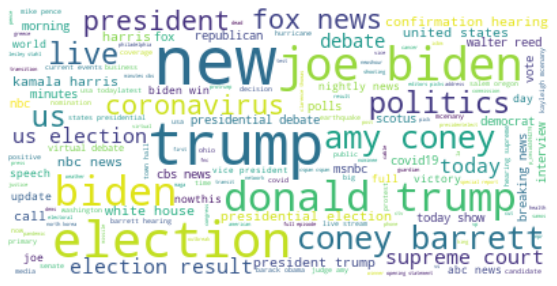

In [85]:
tag_text = " ".join(text for text in df_US.tags[(df_US.category_name == category ) & (dateMask)])
title_text = " ".join(text for text in df_US.video_title[(df_US.category_name == category ) & (dateMask) ])
tag_title_text = tag_text + ' ' + title_text
generate_wordcloud(tag_title_text, stopwords)

### Summary: It can be inferred from the wordcloud that the spike in November was caused because of the elections in USA and it overshadowed the coronavirus second wave related news, which was prevalent during the same time period

#### MAY-JULY 2021

In [86]:
category = 'News & Politics'
dateMask = (df_US.trending_date > pd.Timestamp(2021,4,30)) & (df_US.trending_date < pd.Timestamp(2021,6,1))

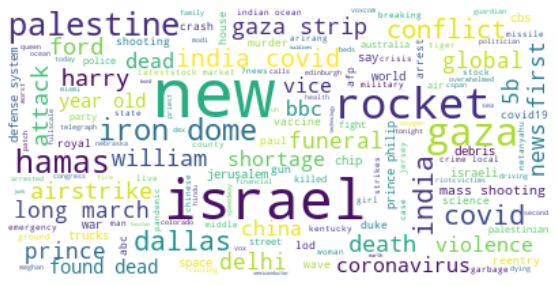

In [87]:
tag_text = " ".join(text for text in df_US.tags[(df_US.category_name == category ) & (dateMask)])
title_text = " ".join(text for text in df_US.video_title[(df_US.category_name == category ) & (dateMask) ])
tag_title_text = tag_text + ' ' + title_text
generate_wordcloud(tag_title_text, stopwords)

#### Summary: It can be inferred form the above wordcloud that the May-July 2021 spike was caused due to 2 major happenings:
#### 1. Hamas attacks on israel
#### 2. Deadly Covid-19 second wave in India

### INSIGHT: Trending Videos with words on sensational happenings in tags and Titles are tending to be viewed more. We can also say that YouTube is biased towards choosing such videos in its Trending Tab. So, if content creators wants to make it to trending Tab, using such words will give the video higher chances to get to trending.


#### -------------------------------------------------------------------------------------------------------------------

### FINDING 2:

### Goal:To find what tags and titles are mostly used in popular categories? Does Americans prefer certain Tags and titles over the British?

To find the popular categories by country

<AxesSubplot:xlabel='count', ylabel='category_name'>

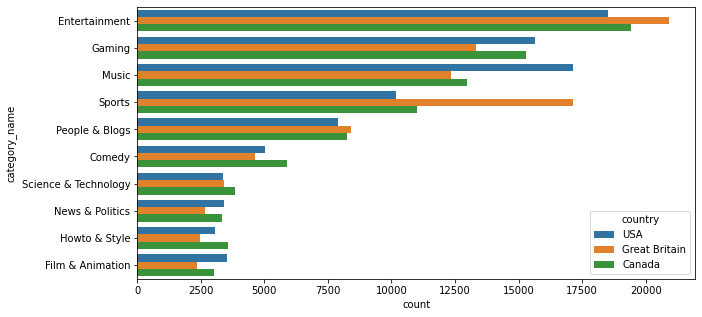

In [88]:
sns.countplot(y='category_name',data=df,hue='country',\
              order=df.category_name.value_counts().iloc[:10].index,hue_order=['USA','Great Britain','Canada'])

##### We observed that Entertainment and Sports are most popular and  anlaysed these two categories to present the contrast.

### USA

In [89]:
category_list = ['Entertainment', 'Sports']

Category: Entertainment


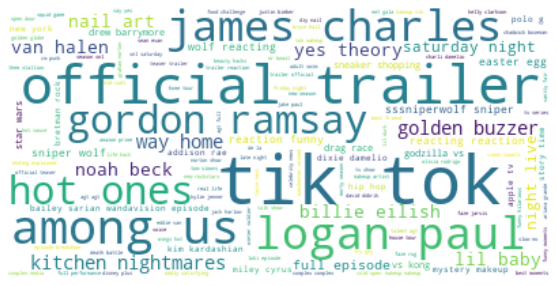

Category: Sports


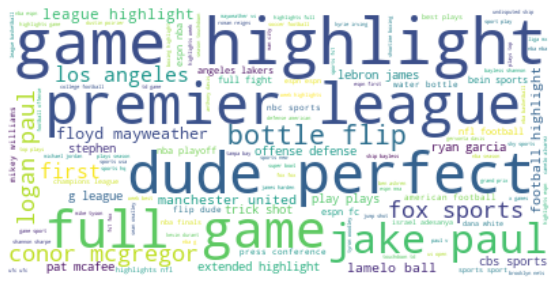

In [90]:
for category in category_list:
    print("Category: "+category)
    tag_text = " ".join(text for text in df.tags[(df.category_name == category )& (df.country == 'USA')])
    title_text = " ".join(text for text in df.video_title[(df.category_name == category )& (df.country == 'USA')])
    tag_title_text = tag_text + ' ' + title_text
    generate_wordcloud(tag_title_text, stopwords)

### Great Britain

Category: Entertainment


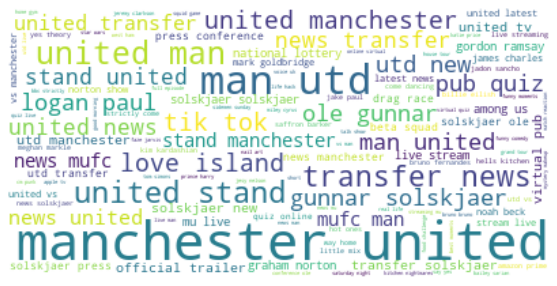

Category: Sports


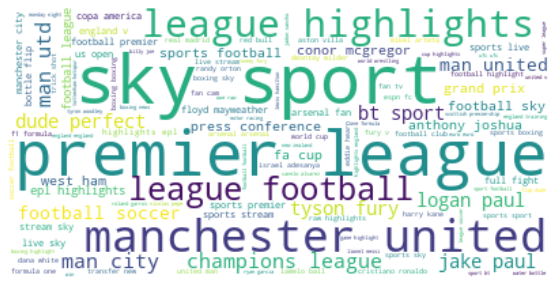

In [91]:
for category in category_list:
    print("Category: "+category)
    tag_text = " ".join(text for text in df.tags[(df.category_name == category )& (df.country == 'Great Britain')])
    title_text = " ".join(text for text in df.video_title[(df.category_name == category )& (df.country == 'Great Britain')])
    tag_title_text = tag_text + ' ' + title_text
    generate_wordcloud(tag_title_text, stopwords)

### Does Americans prefer certain Tags and titles over the British? 

### Finding: Yes. In USA , people have varied interests in both the categories. Whereas, in Great Britain , The most watched videos are predominantly Football and more exclusively Manchester United in 2020-21.


### INSIGHT:

### Knowing what is trending in videos could help businesses target advertisements specific to viewer country and taste. 


#### --------------------------------------------------------------------------------------------------------------

### FINDING 3: (MACHINE LEARNING)

In [92]:
df = pd.read_csv('Clean_Dataset_final.csv.zip')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277115 entries, 0 to 277114
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   video_id       277115 non-null  object
 1   published_at   277115 non-null  object
 2   category_id    277115 non-null  int64 
 3   trending_date  277115 non-null  object
 4   view_count     277115 non-null  int64 
 5   likes          277115 non-null  int64 
 6   dislikes       277115 non-null  int64 
 7   comment_count  277115 non-null  int64 
 8   category_name  277115 non-null  object
 9   country        277115 non-null  object
 10  description    272206 non-null  object
 11  tags           232288 non-null  object
 12  video_title    276962 non-null  object
 13  channel_title  276746 non-null  object
dtypes: int64(5), object(9)
memory usage: 29.6+ MB


#### Keeping only one unique record of each video_id

In [94]:
df.drop_duplicates(subset=['video_id'], keep='last', inplace = True)

#### Dropping columns except title description and tags which will help us to predict category

In [95]:
df.drop(columns=['channel_title','video_id','published_at', 'category_id','trending_date',\
                 'view_count', 'likes', 'dislikes', 'comment_count', 'country'],axis=1,inplace=True)

In [96]:
df.fillna(value = '', inplace = True)

In [97]:
# Combining all text data in a single column:

df['All_text'] = df.description + ' ' + df.tags + ' ' + df.video_title

In [98]:
pd.set_option("display.max_colwidth", -1)

In [99]:
df.head(1)

category_name  \
172  Howto & Style   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           description  \
172  today i show you how to make a curried egg sandwich curried egg sandwiches are my favourite snack they are easy to make and incredibly tasty unfortunately not many people know how to make one correctly  that changes today enjoyclick here to eggscribe a video suggestion post it in the comments section contact me through my facebook page or tweet meconnect with mefacebook    channel   howtobasic shirts and egg plushies someone that likes curried egg sandwiches link this delicious recipe to them   

                                                                                                                                                                                                                                                tags  \
172  how to make a curried egg sandwich curried egg egg sandwich recipe egg recipe how to make a sandwich curried egg sandwich recipe easy recipe curry recipe how to make curry food step by step recipes healthy recipes egg salad sandwich recipe   

                            video_title  \
172  how to make a curried egg sandwich   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 All_text  
172  today i show you how to make a curried egg sandwich curried egg sandwiches are my favourite snack they are easy to make and incredibly tasty unfortunately not many people know how to make one correctly  that changes today enjoyclick here to eggscribe a video suggestion post it in the comments section contact me through my facebook page or tweet meconnect with mefacebook    channel   howtobasic shirts and egg plushies someone that likes curried egg sandwiches link this delicious recipe to them how to make a curried egg sandwich curried egg egg sandwich recipe egg recipe how to make a sandwich curried egg sandwich recipe easy recipe curry recipe how to make curry food step by step recipes healthy recipes egg salad sandwich recipe how to make a curried egg sandwich

In [100]:
df.drop(columns=['description', 'tags', 'video_title'],axis=1,inplace=True)

In [101]:
df.head(1)

category_name  \
172  Howto & Style   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 All_text  
172  today i show you how to make a curried egg sandwich curried egg sandwiches are my favourite snack they are easy to make and incredibly tasty unfortunately not many people know how to make one correctly  that changes today enjoyclick here to eggscribe a video suggestion post it in the comments section contact me through my facebook page or tweet meconnect with mefacebook    channel   howtobasic shirts and egg plushies someone that likes curried egg sandwiches link this delicious recipe to them how to make a curried egg sandwich curried egg egg sandwich recipe egg recipe how to make a sandwich curried egg sandwich recipe easy recipe curry recipe how to make curry food step by step recipes healthy recipes egg salad sandwich recipe how to make a curried egg sandwich

### Stopword Removal and Word Stemming

#### Defining a function to remove stop words and perform word stemming(which converts word into it's root form)

In [102]:
def preprocessing(text):
    stemmer = PorterStemmer()
    processed_text = ''
    for word in text.split():
        if not word in stopwords:
            processed_text += stemmer.stem(word) + " "

    return processed_text

#### Validating preprocessing method :

In [103]:
test = "today i show you how to make a curried egg sandwich curried egg sandwiches are my favourite snack they are easy to make and incredibly tasty unfortunately not many people know how to make one correctly that changes today enjoyclick here to eggscribe a video suggestion post it in the comments section contact me through my facebook page or tweet meconnect with mefacebook channel howtobasic shirts and egg plushies someone that likes curried egg sandwiches link this delicious recipe to them how to make a curried egg sandwich curried egg egg sandwich recipe egg recipe how to make a sandwich curried egg sandwich recipe easy recipe curry recipe how to make curry food step by step recipes healthy recipes egg salad sandwich recipe how to make a curried egg sandwich"

In [104]:
preprocessing(test)

'today show curri egg sandwich curri egg sandwich favourit snack easi incred tasti unfortun mani peopl know one correctli chang today enjoyclick eggscrib suggest post comment section contact page tweet meconnect mefacebook howtobas shirt egg plushi someon like curri egg sandwich link delici recip curri egg sandwich curri egg egg sandwich recip egg recip sandwich curri egg sandwich recip easi recip curri recip curri food step step recip healthi recip egg salad sandwich recip curri egg sandwich '

In [105]:
df['All_text'] = df['All_text'].apply(preprocessing)

#### Classification for Prediction

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [107]:
df.category_name.value_counts()

Entertainment            6315
Sports                   5719
Music                    4172
Gaming                   3805
People & Blogs           2527
Comedy                   1588
News & Politics          1224
Howto & Style            923 
Science & Technology     906 
Film & Animation         754 
Autos & Vehicles         584 
Education                559 
Travel & Events          170 
Pets & Animals           148 
Nonprofits & Activism    25  
Name: category_name, dtype: int64

#### Doing prediction for categories with higher value counts to keep the dataset balanced

-df_filtered - the dataframe only with categories 'Entertainment', 'Sports', 'Music', 'Gaming','People & Blogs', 'Comedy','News & Politics'

In [108]:
df_filtered = df[df.category_name.isin(['Entertainment', 'Sports', 'Music', 'Gaming', \
                                        'People & Blogs', 'Comedy','News & Politics'])]

In [109]:
X = df_filtered.All_text

In [110]:
Y = df_filtered.category_name

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state = 0)

### Bag of Words Model: It is represnetation of text that describes the occurence of words within a document. We use this to convert text into numerical representation and use it in the classification model

In [112]:
# Applying bag of words to features in training and testing data
bag_of_words_creator = CountVectorizer()
X_train_bow = bag_of_words_creator.fit_transform(X_train)
X_test_bow = bag_of_words_creator.transform(X_test)

In [113]:
#cl = RandomForestClassifier(random_state = 0, n_estimators=1000)
cl = RandomForestClassifier(random_state = 0)
cl.fit(X_train_bow,Y_train)

RandomForestClassifier(random_state=0)

In [114]:
y_pred = cl.predict(X_test_bow)

#### Confusion Matrix

In [115]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met

In [116]:
confusion_matrix(Y_test,y_pred)

array([[ 278,  120,   19,   14,    4,   26,    8],
       [  26, 1575,   57,   93,   14,   94,   42],
       [   8,   43, 1075,   12,    0,   19,   12],
       [   9,   38,    5, 1155,    1,    6,    2],
       [   4,   23,    0,    7,  312,    6,   15],
       [  19,  200,   38,   60,    6,  448,   17],
       [   2,   27,    3,    7,    2,   14, 1640]])

#### Using classification report which gives us metric like 'precision', 'recall'and 'f1 score' for all the categories taken into consideration

In [117]:
print(met.classification_report(Y_test,y_pred))

                 precision    recall  f1-score   support

         Comedy       0.80      0.59      0.68       469
  Entertainment       0.78      0.83      0.80      1901
         Gaming       0.90      0.92      0.91      1169
          Music       0.86      0.95      0.90      1216
News & Politics       0.92      0.85      0.88       367
 People & Blogs       0.73      0.57      0.64       788
         Sports       0.94      0.97      0.96      1695

       accuracy                           0.85      7605
      macro avg       0.85      0.81      0.82      7605
   weighted avg       0.85      0.85      0.85      7605



#### Since we are predicting multiclass, we cannot calculate AUC acore in our scenario

### TFIDF Concept: It is another form of feature representation of textual data. In simple words, it assigns weight to every word depending on how unique a word is to a given document. Weight of every word is proportional to the frequency of that word in it's own document/text and inversly proportional to occurence in the other documents/texts

In [118]:
tfidf_creator = TfidfVectorizer()
X_train_tfidf = tfidf_creator.fit_transform(X_train)
X_test_tfidf = tfidf_creator.transform(X_test)

In [119]:
#cl = RandomForestClassifier(random_state = 0, n_estimators=1000)
cl = RandomForestClassifier(random_state = 0)
cl.fit(X_train_tfidf,Y_train)

RandomForestClassifier(random_state=0)

In [120]:
y_pred = cl.predict(X_test_tfidf)

#### Confusion Matrix

In [121]:
confusion_matrix(Y_test,y_pred)

array([[ 266,  135,   26,   11,    2,   19,   10],
       [  23, 1603,   54,   85,   13,   80,   43],
       [   5,   55, 1074,    7,    0,   14,   14],
       [   5,   39,    3, 1161,    1,    5,    2],
       [   3,   26,    0,    7,  311,    7,   13],
       [  18,  227,   42,   57,    5,  420,   19],
       [   3,   35,    3,    4,    4,    7, 1639]])

#### Using classification report which gives us metric like 'precision', 'recall'and 'f1 score' for all the categories taken into consideration

In [122]:
print(met.classification_report(Y_test,y_pred))

                 precision    recall  f1-score   support

         Comedy       0.82      0.57      0.67       469
  Entertainment       0.76      0.84      0.80      1901
         Gaming       0.89      0.92      0.91      1169
          Music       0.87      0.95      0.91      1216
News & Politics       0.93      0.85      0.88       367
 People & Blogs       0.76      0.53      0.63       788
         Sports       0.94      0.97      0.95      1695

       accuracy                           0.85      7605
      macro avg       0.85      0.80      0.82      7605
   weighted avg       0.85      0.85      0.85      7605



## Managerial Insight: 
- From this ML Model, We can find out the missing category of any video, based on the information obtained from title, tag and description
         
- A platform like youtube can use this model to recommend the category to the users by doing real time analysis on title, tag and description while they are uploading their videos

### --------------------------------------------------------------------------------------------------------------

## Finding 4

### GOAL: To construct a Machine learning model to predict how many more days a video will trend given views,likes,dislikes,comment_count, published date and trending day number

In [123]:
df = pd.read_csv('Clean_Dataset_final.csv.zip')

#### Prepare the dataset fo Machine learning

#### For each video_id and trending_date extract the maximun view_count,Likes,Dislikes,Comment_count 

In [124]:
ML_df= df.groupby(['video_id','trending_date','published_at'],as_index=False).agg({'view_count':\
                                                             'max','likes':'max','dislikes':'max','comment_count':'max'})

#### cross checking the values to see all the days a video was trending

In [125]:
ML_df[ML_df.video_id=='9Lhbm87KmOc']

video_id        trending_date         published_at  view_count  \
25636  9Lhbm87KmOc  2021-11-05 00:00:00  2021-11-04 15:00:08  1499810      
25637  9Lhbm87KmOc  2021-11-06 00:00:00  2021-11-04 15:00:08  2123516      
25638  9Lhbm87KmOc  2021-11-07 00:00:00  2021-11-04 15:00:08  2368472      
25639  9Lhbm87KmOc  2021-11-08 00:00:00  2021-11-04 15:00:08  2564579      
25640  9Lhbm87KmOc  2021-11-09 00:00:00  2021-11-04 15:00:08  2718668      
25641  9Lhbm87KmOc  2021-11-10 00:00:00  2021-11-04 15:00:08  2831812      

        likes  dislikes  comment_count  
25636  76792   540       8114           
25637  96213   708       9845           
25638  104490  797       10495          
25639  111414  867       10945          
25640  116626  913       11368          
25641  120078  946       11617

In [126]:
df1 = ML_df.copy()

In [127]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157671 entries, 0 to 157670
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   video_id       157671 non-null  object
 1   trending_date  157671 non-null  object
 2   published_at   157671 non-null  object
 3   view_count     157671 non-null  int64 
 4   likes          157671 non-null  int64 
 5   dislikes       157671 non-null  int64 
 6   comment_count  157671 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 9.6+ MB


#### 

In [128]:
df1['trending_date'] = pd.to_datetime(df1['trending_date'])
df1['published_at'] = pd.to_datetime(df1['published_at'])

#### Each video trends for multiple days so we are creating a new feature 'trending_day_no' which will give us the current trending day number for each record
- We are adding this feature to retain the metrics like likes, dislikes, view, comment_count for each trending day number
- To use it for predicting how many more days a video can trend

In [129]:
df1['trending_day_no'] = df1.groupby(['video_id'])["trending_date"].rank('first',ascending=True)

#### Calculating total trending days for each video

In [130]:
df1_count = df1.groupby('video_id',as_index=False)["trending_date"].count().rename(columns={\
                                                                'trending_date':'total_trending_days'})

In [131]:
df2 = df1.merge(df1_count, left_on='video_id', right_on='video_id')
df2.head()

video_id trending_date        published_at  view_count  likes  dislikes  \
0  --0bCF-iK2E 2021-07-04    2021-07-01 10:00:00  304339      8753   76         
1  --0bCF-iK2E 2021-07-05    2021-07-01 10:00:00  361948      10020  93         
2  --0bCF-iK2E 2021-07-06    2021-07-01 10:00:00  398274      10750  100        
3  --0bCF-iK2E 2021-07-07    2021-07-01 10:00:00  419194      11108  106        
4  --0bCF-iK2E 2021-07-08    2021-07-01 10:00:00  433340      11276  110        

   comment_count  trending_day_no  total_trending_days  
0  988           1.0000            5                    
1  1044          2.0000            5                    
2  1067          3.0000            5                    
3  1077          4.0000            5                    
4  1083          5.0000            5

In [132]:
df2.corr()

view_count  likes  dislikes  comment_count  \
view_count          1.0000      0.8326 0.7419    0.4673           
likes               0.8326      1.0000 0.6821    0.6792           
dislikes            0.7419      0.6821 1.0000    0.4742           
comment_count       0.4673      0.6792 0.4742    1.0000           
trending_day_no     0.2451      0.1722 0.1503    0.0528           
total_trending_days 0.3149      0.2439 0.1938    0.0804           

                     trending_day_no  total_trending_days  
view_count          0.2451           0.3149                
likes               0.1722           0.2439                
dislikes            0.1503           0.1938                
comment_count       0.0528           0.0804                
trending_day_no     1.0000           0.4728                
total_trending_days 0.4728           1.0000

#### Checking data for a specific video_id

In [133]:
df2[df2['video_id'] == '9Lhbm87KmOc']

video_id trending_date        published_at  view_count   likes  \
25636  9Lhbm87KmOc 2021-11-05    2021-11-04 15:00:08  1499810     76792    
25637  9Lhbm87KmOc 2021-11-06    2021-11-04 15:00:08  2123516     96213    
25638  9Lhbm87KmOc 2021-11-07    2021-11-04 15:00:08  2368472     104490   
25639  9Lhbm87KmOc 2021-11-08    2021-11-04 15:00:08  2564579     111414   
25640  9Lhbm87KmOc 2021-11-09    2021-11-04 15:00:08  2718668     116626   
25641  9Lhbm87KmOc 2021-11-10    2021-11-04 15:00:08  2831812     120078   

       dislikes  comment_count  trending_day_no  total_trending_days  
25636  540       8114          1.0000            6                    
25637  708       9845          2.0000            6                    
25638  797       10495         3.0000            6                    
25639  867       10945         4.0000            6                    
25640  913       11368         5.0000            6                    
25641  946       11617         6.0000            6

In [134]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157671 entries, 0 to 157670
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   video_id             157671 non-null  object        
 1   trending_date        157671 non-null  datetime64[ns]
 2   published_at         157671 non-null  datetime64[ns]
 3   view_count           157671 non-null  int64         
 4   likes                157671 non-null  int64         
 5   dislikes             157671 non-null  int64         
 6   comment_count        157671 non-null  int64         
 7   trending_day_no      157671 non-null  float64       
 8   total_trending_days  157671 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 12.0+ MB


In [135]:
df2['published_year'] = df2.published_at.dt.year
df2['published_month'] = df2.published_at.dt.month
df2['published_day'] = df2.published_at.dt.day
df2['published_hour'] = df2.published_at.dt.hour
df2['published_minute'] = df2.published_at.dt.minute
df2['published_week'] = df2.published_at.dt.week

In [136]:
df2.drop(columns=['video_id', 'trending_date', 'published_at'],inplace=True) 

Now the dataset is ready for Machine learning

In [137]:
df2.head()

view_count  likes  dislikes  comment_count  trending_day_no  \
0  304339      8753   76        988           1.0000             
1  361948      10020  93        1044          2.0000             
2  398274      10750  100       1067          3.0000             
3  419194      11108  106       1077          4.0000             
4  433340      11276  110       1083          5.0000             

   total_trending_days  published_year  published_month  published_day  \
0  5                    2021            7                1               
1  5                    2021            7                1               
2  5                    2021            7                1               
3  5                    2021            7                1               
4  5                    2021            7                1               

   published_hour  published_minute  published_week  
0  10              0                 26              
1  10              0                 26              
2  10              0                 26              
3  10              0                 26              
4  10              0                 26

### Make X,Y

In [138]:
X = df2.drop('total_trending_days',axis=1)
Y = df2.total_trending_days

Build and Train

In [139]:
import sklearn.tree

In [140]:
dt = sklearn.tree.DecisionTreeRegressor(max_depth = 2)

In [141]:
dt.fit(X,Y)

DecisionTreeRegressor(max_depth=2)

Visualize the tree

In [142]:
Y.mean()

5.942811296941099

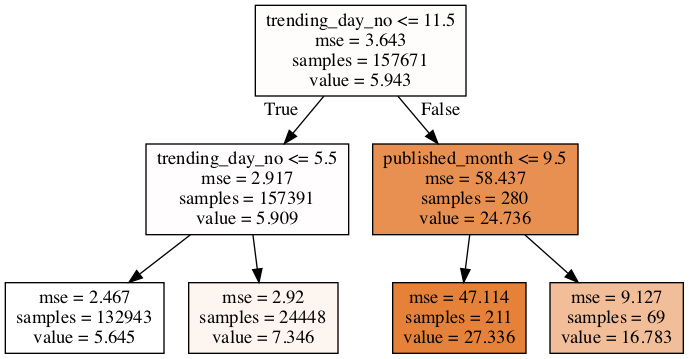

In [143]:
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

#### Tree Interpretation: If the trending days are less than 11.5, we can predict with higher accuracy total number of trending days for a video since on an average video trends for approximately 6 days. Since the data for videos which trend for more than 12 days is very less we see a high MSE score on the right side of the tree

In [144]:
Y.value_counts()

6     43230
5     36150
7     31073
4     18620
8     12960
3     5457 
9     4410 
10    1950 
2     1650 
1     846  
11    605  
12    144  
36    72   
24    48   
23    46   
15    45   
20    40   
13    39   
18    36   
17    34   
34    34   
16    32   
29    29   
14    28   
27    27   
26    26   
21    21   
19    19   
Name: total_trending_days, dtype: int64

In [145]:
trending_days_binned = pd.cut(Y, bins= [0,4,9,40])
trending_days_binned_count = trending_days_binned.value_counts().rename_axis('Binned_Trending_Days').reset_index(name = 'Count')

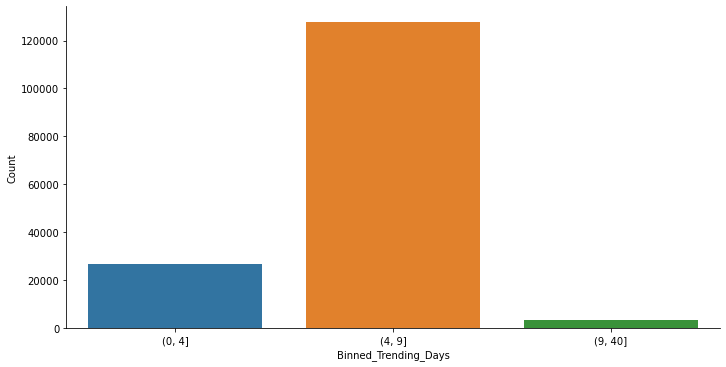

In [146]:
sns.catplot( y='Count',x='Binned_Trending_Days',\
            data=trending_days_binned_count,kind='bar', aspect = 2)

### Finding: Majority of the trending videos are trending for total 4 to 9 days so the decision tree regressor gives a better prediction for videos in that bin range

### Mangerial Insight: A video that performs well on the trending page will be surfaced to more people and helps in the better the reach of the channel. So, by using this model, channels could estimate their total number of days their video could trend based on the number of views, likes, dislikes and comments the video is receiving.

### Regression for Prediction

In [147]:
X = df2.drop('total_trending_days',axis=1)
Y = df2.total_trending_days

Splitting X and Y for training and test

In [148]:
from sklearn.model_selection import train_test_split

In [149]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                            test_size=0.3,random_state=0)

Train and predict with LinearRegession

In [150]:
from sklearn import linear_model

In [151]:
regr = linear_model.LinearRegression()

In [152]:
regr.fit(X_train,Y_train)

LinearRegression()

In [153]:
y_pred = regr.predict(X_test)

In [154]:
y_pred

array([7.33726665, 6.41044498, 5.74882481, ..., 5.25869201, 6.51654887,
       6.2732937 ])

#### Finding the coefficients

In [155]:
print("Coefficients: \n", regr.coef_)

Coefficients: 
 [ 6.78397362e-08  3.02357149e-07 -8.49373026e-06 -1.47446349e-06
  3.89498091e-01 -2.97693789e-01 -1.26530235e-01 -6.13502341e-03
 -1.61209659e-03 -2.99638272e-03  1.37144317e-02]


#### Coefficient Determination

In [156]:
r2_score=sklearn.metrics.r2_score(Y_test, y_pred)

In [157]:
print("Coefficient of determination: %.2f" % r2_score)

Coefficient of determination: 0.26


### Metrics

#### Mean Absolute Error and Mean Absolute deviation

#### MAD

In [158]:
(y_pred-Y_test).abs().mean()

1.1358580446855684

#### Mean Squared Error/MSE

In [159]:
((y_pred-Y_test)**2).mean()

2.6792137098922284

#### Calculating best regressor for the dataset

In [160]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

regs = [Lasso(), ElasticNet(), DecisionTreeRegressor(), GradientBoostingRegressor(), MLPRegressor()]
 

Goal is to find the predictor which minimized the cross-validated MAD

In [161]:
from sklearn.model_selection import KFold

In [162]:
minMAD = 10000000
nfolds = 3
bestREG = ''

for reg in regs:
    kf = KFold(n_splits=nfolds,random_state=0,shuffle=True)
    mad = sklearn.model_selection.cross_val_score(reg,X,Y,\
             cv=kf,scoring='neg_mean_absolute_error').mean()
    # need the lowest scoring for mad
    print (str(reg)[:25] + ' with mad= ' + str(mad) )
    if mad < minMAD:
        minMAD = mad
        bestREG = reg
        
print('***********************************************')
print ('Best Regressor is... ' + str(bestREG)[:25] )
print('**********************')
print ('With MAD Score ' + str(minMAD))

Lasso() with mad= -1.1600336751190794
ElasticNet() with mad= -1.1361904501933953
DecisionTreeRegressor() with mad= -0.6818374970666768
GradientBoostingRegressor with mad= -0.9132557796936741
MLPRegressor() with mad= -377.8684605560439
***********************************************
Best Regressor is... MLPRegressor()
**********************
With MAD Score -377.8684605560439
